# Term Project Code
Frank Wills, Molly Hutchinson



In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.preprocessing import MinMaxScaler
from  sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [2]:
# read and process text files
def process_transcripts(df, attr):
    results = []
    for row, view in zip(df['transcript'], df[attr]):
            temp_df = process(row, view, attr)
            results.append(temp_df)

    final_df = pd.concat(results, ignore_index = True)
    return final_df

def process(row, view, attr):
    """book is the book's text as a string. 
    'author' is the file name, from which the author is extracted.
    processes data and compiles it into a dataframe
    """
    rows = get_rows(row)
    df = pd.DataFrame(rows, columns=["transcript"])
    df[attr] = view
    return df

def word_frequency(tokens):
    """Plot the most common tokens in the text.
    The distribution is returned."""
    dist = nltk.FreqDist(tokens)
    dist.plot(25, cumulative=False)
    return dist


def get_rows(row, chunk_size = 1000):
    """Chunk book text into rows of 500 tokens using word_tokenize"""
    toks = word_tokenize(row)
    toks = list(cleanup(toks))
    #word_frequency(toks)
    to_pad = chunk_size - len(toks) % chunk_size
    toks.extend(['' for i in range(to_pad)])
    array = np.array(toks)
    array = array.reshape(-1, chunk_size)
    return [' '.join(e) for e in array]

def cleanup(tokens):
    """stopwords, punctuation, quotations, and digits are all
    removed using this function."""
    stop = stopwords.words('english')
    toremove = string.punctuation + "—" + "♫"
    tab = "".maketrans("", "", toremove)
    tokens = [t.translate(tab) for t in tokens]
    return filter(None, remove_tokens(tokens, stop))

def remove_tokens(tokens, stopwords):
    """Takes list of tokens and returns list with stopwords removed."""
    return [t for t in tokens if t not in stopwords]

In [3]:
def parse_sotu(filename):
    sotu_path = "SOTU/"
    f = open(sotu_path+filename)
    return f.read()

def remap_party(x):
    if(x['party']=='R'):
        return 'Republican'
    elif (x['party']=='D'):
        return 'Democrat'
    else:
        return 'Other'
    
        
# combine file manifest with text input
dfmanifest = pd.read_csv('file_manifest.csv')
dfmanifest['transcript'] = dfmanifest.apply(lambda x:parse_sotu(x['file']),axis=1)
# combine third parties
dfmanifest['partychar'] = dfmanifest['party']
dfmanifest['party'] = dfmanifest.apply(lambda x:remap_party(x),axis=1)
print(dfmanifest)

                    file  year   president       party  \
0    Washington_1791.txt  1791  Washington       Other   
1    Washington_1792.txt  1792  Washington       Other   
2    Washington_1793.txt  1793  Washington       Other   
3    Washington_1794.txt  1794  Washington       Other   
4    Washington_1795.txt  1795  Washington       Other   
..                   ...   ...         ...         ...   
222       Obama_2014.txt  2014       Obama    Democrat   
223       Obama_2015.txt  2015       Obama    Democrat   
224       Obama_2016.txt  2016       Obama    Democrat   
225       Trump_2017.txt  2017       Trump  Republican   
226       Trump_2018.txt  2018       Trump  Republican   

                                            transcript partychar  
0    Fellow-Citizens of the Senate and House of Rep...         U  
1    Fellow-Citizens of the Senate and House of Rep...         U  
2    Fellow-Citizens of the Senate and House of Rep...         U  
3    Fellow-Citizens of the Senate 

In [4]:
#putting the training and testing up here so that they may be shared by the different models
#as opposed to being different for each

train, test = train_test_split(dfmanifest, test_size=0.25)
dftrain = process_transcripts(train, 'party')
dftest = process_transcripts(test, 'party')

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dftrain['transcript'])
X_test_counts = count_vect.transform(dftest['transcript'])

#train, test = train_test_split(dfmanifest, test_size=0.25)
dftrain2 = process_transcripts(train, 'partychar')
dftest2 = process_transcripts(test, 'partychar')

count_vect = CountVectorizer()
X_train_counts2 = count_vect.fit_transform(dftrain2['transcript'])
X_test_counts2 = count_vect.transform(dftest2['transcript'])

# Naive Bayes

In [5]:
def test(attr):
    
#     train, test = train_test_split(dfmanifest, test_size=0.2)
#     dftrain = process_transcripts(train, attr)
#     dftest = process_transcripts(test, attr)

#     count_vect = CountVectorizer()
#     X_train_counts = count_vect.fit_transform(dftrain['transcript'])
#     X_test_counts = count_vect.transform(dftest['transcript'])

    global X_train_counts
    global X_test_counts
    
    
    learnerM = MultinomialNB()
    learnerB = BernoulliNB()
    
    clfM = learnerM.fit(X_train_counts, dftrain[attr])
    clfB = learnerB.fit(X_train_counts, dftrain[attr])
    
    #makes predictions
    predicted_mult = clfM.predict(X_test_counts)
    predicted_ber = clfB.predict(X_test_counts)

    #confusion matrix for multinominal
    cm = confusion_matrix(dftest[attr], predicted_mult)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clfM.classes_)
    #disp.ax_.set_title("Multinomial")
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.title("Multinominal")
    plt.show()
    #calculates and prints accuracy for multinominal
    print("accuracy of multinomial: ", np.mean(predicted_mult == dftest[attr]))
    
    #confusion matrix for bernoulli
    cmb = confusion_matrix(dftest[attr], predicted_ber)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cmb, display_labels=clfB.classes_)
    #disp2.ax_.set_title("Bernoulli")
    disp2.plot(cmap=plt.cm.Blues,values_format='g')
    plt.title("Bernoulli")
    plt.show()
    #calculates and prints accuracy for bernoulli
    print("accuracy of bernoulli: ", np.mean(predicted_ber == dftest[attr]))

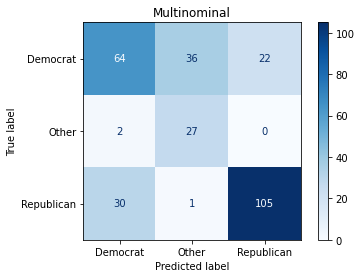

accuracy of multinomial:  0.6829268292682927


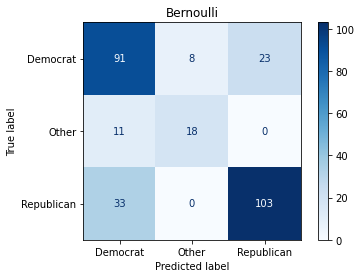

accuracy of bernoulli:  0.7386759581881533


In [6]:
test('party')

In [7]:
def test2(attr):
    
    global X_train_counts2
    global X_test_counts2
    global dftrain2
    global dftest2
    
    labels = ['D', 'DR', 'F', 'R', 'U', 'W']
    
    learnerM = MultinomialNB()
    learnerB = BernoulliNB()
    
    clfM = learnerM.fit(X_train_counts2, dftrain2[attr])
    clfB = learnerB.fit(X_train_counts2, dftrain2[attr])
    
    #makes predictions
    predicted_mult = clfM.predict(X_test_counts2)
    predicted_ber = clfB.predict(X_test_counts2)

    #confusion matrix for multinominal
    cm = confusion_matrix(dftest2[attr], predicted_mult, labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clfM.classes_)
    
   # print(disp.xticks())
    
    #disp.ax_.set_title("Multinomial")
    disp.plot(cmap=plt.cm.Blues)#,values_format='g')
    plt.title("Multinominal")
    plt.show()
    #calculates and prints accuracy for multinominal
    print("accuracy of multinomial: ", np.mean(predicted_mult == dftest2[attr]))
    
    #confusion matrix for bernoulli
    cmb = confusion_matrix(dftest2[attr], predicted_ber, labels)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cmb, display_labels=clfB.classes_)
    #disp2.ax_.set_title("Bernoulli")
    disp2.plot(cmap=plt.cm.Blues)#,values_format='g')
    plt.title("Bernoulli")
    plt.show()
    #calculates and prints accuracy for bernoulli
    print("accuracy of bernoulli: ", np.mean(predicted_ber == dftest2[attr]))

C:\Users\frank\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['D', 'DR', 'F', 'R', 'U', 'W'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


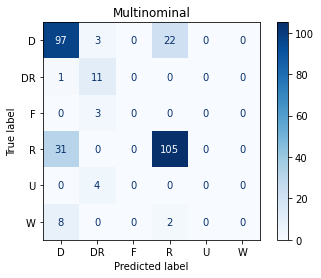

accuracy of multinomial:  0.7421602787456446


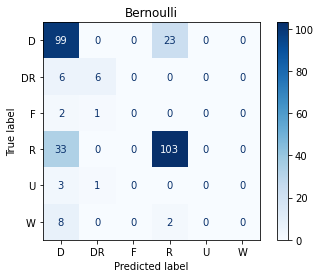

accuracy of bernoulli:  0.7247386759581882


In [8]:
test2('partychar')

In [9]:
# python directory utility
from os import listdir
from os.path import isfile, join
filenames = [f for f in listdir("SOTU/") if f[-4:]==".txt"]
for f in filenames:
    print(f+", "+f[-8:-4]+", "+f[:-9])

Adams_1797.txt, 1797, Adams
Adams_1798.txt, 1798, Adams
Adams_1799.txt, 1799, Adams
Adams_1800.txt, 1800, Adams
Adams_1825.txt, 1825, Adams
Adams_1826.txt, 1826, Adams
Adams_1827.txt, 1827, Adams
Adams_1828.txt, 1828, Adams
Arthur_1881.txt, 1881, Arthur
Arthur_1882.txt, 1882, Arthur
Arthur_1883.txt, 1883, Arthur
Arthur_1884.txt, 1884, Arthur
Buchanan_1857.txt, 1857, Buchanan
Buchanan_1858.txt, 1858, Buchanan
Buchanan_1859.txt, 1859, Buchanan
Buchanan_1860.txt, 1860, Buchanan
Buren_1837.txt, 1837, Buren
Buren_1838.txt, 1838, Buren
Buren_1839.txt, 1839, Buren
Buren_1840.txt, 1840, Buren
Bush_1989.txt, 1989, Bush
Bush_1990.txt, 1990, Bush
Bush_1991.txt, 1991, Bush
Bush_1992.txt, 1992, Bush
Bush_2001.txt, 2001, Bush
Bush_2002.txt, 2002, Bush
Bush_2003.txt, 2003, Bush
Bush_2004.txt, 2004, Bush
Bush_2005.txt, 2005, Bush
Bush_2006.txt, 2006, Bush
Bush_2007.txt, 2007, Bush
Bush_2008.txt, 2008, Bush
Carter_1978.txt, 1978, Carter
Carter_1979.txt, 1979, Carter
Carter_1980.txt, 1980, Carter
Carter

# KNN Code

In [10]:
def kneighbortest(attr):

    global X_train_counts
    global X_test_counts
    
    #we have to do this so that it works with knn. 
    #takes count matrix and normalizes to tf-idf reprentation
    tfidf_transformer = TfidfTransformer()
    X_train_counts = tfidf_transformer.fit_transform(X_train_counts)
    X_test_counts = tfidf_transformer.fit_transform(X_test_counts)
    
#     knn1_neighbors = findneighbors(X_train_counts, dftrain[attr], 'brute')
#     print('brute k = ', knn1_neighbors)
# #     knn2_neighbors = findneighbors(X_train_counts, dftrain[attr], 'kd_tree')
# #     print('kd tree k = ', knn2_neighbors)
#     knn3_neighbors = findneighbors(X_train_counts, dftrain[attr], 'ball_tree')
#     print('ball tree k = ', knn3_neighbors)
        
    #fit
    knn1 = KNeighborsClassifier(n_neighbors=2, algorithm='brute' )
    #knn1 = KNeighborsClassifier()
    knn1.fit(X_train_counts, dftrain[attr]) 

    knn2 = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
    knn2.fit(X_train_counts, dftrain[attr]) 

    knn3 = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree')
    knn3.fit(X_train_counts, dftrain[attr]) 

    #predict
    predictedKnn1 = np.array(knn1.predict(X_test_counts))
    predictedKnn2 = np.array(knn2.predict(X_test_counts))
    predictedKnn3 = np.array(knn3.predict(X_test_counts))
    
    #print confusion matrices
    cm = confusion_matrix(dftest[attr], predictedKnn1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn1.classes_)
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.title("Brute Algorithm")
    plt.show()
    
    cm = confusion_matrix(dftest[attr], predictedKnn2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn2.classes_)
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.title("KD Tree Algorithm")
    plt.show()

    
    cm = confusion_matrix(dftest[attr], predictedKnn3)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn3.classes_)
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.title("Ball Tree Algorithm")
    plt.show()

    #print accuracies
    print("accuracy (brute):", metrics.accuracy_score(predictedKnn1,dftest[attr]))
    print("accuracy (kd-tree):",metrics.accuracy_score(predictedKnn2,dftest[attr]))
    print("accuracy (ball):",metrics.accuracy_score(predictedKnn3,dftest[attr]))


C:\Users\frank\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\frank\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


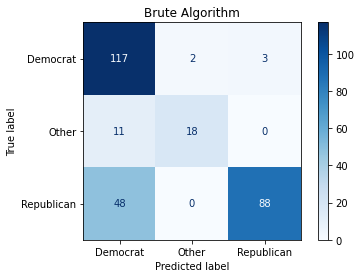

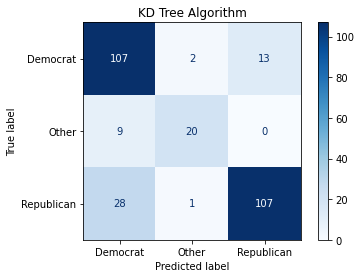

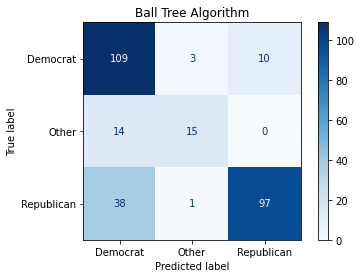

accuracy (brute): 0.7770034843205574
accuracy (kd-tree): 0.8153310104529616
accuracy (ball): 0.7700348432055749


In [11]:
kneighbortest('party')

In [12]:
def kneighbortest2(attr):

    global X_train_counts2
    global X_test_counts2
    global dftrain2
    global dftest2
    
    labels = ['D', 'DR', 'F', 'R', 'U', 'W']
    
    #we have to do this so that it works with knn. 
    #takes count matrix and normalizes to tf-idf reprentation
    tfidf_transformer = TfidfTransformer()
    X_train_counts2 = tfidf_transformer.fit_transform(X_train_counts2)
    X_test_counts2 = tfidf_transformer.fit_transform(X_test_counts2)
        
    #fit
    knn1 = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    knn1.fit(X_train_counts2, dftrain2[attr]) 

    knn2 = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
    knn2.fit(X_train_counts2, dftrain2[attr]) 

    knn3 = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree')
    knn3.fit(X_train_counts2, dftrain2[attr]) 

    #predict
    predictedKnn1 = np.array(knn1.predict(X_test_counts2))
    predictedKnn2 = np.array(knn2.predict(X_test_counts2))
    predictedKnn3 = np.array(knn3.predict(X_test_counts2))
    
    #print confusion matrices
    cm = confusion_matrix(dftest2[attr], predictedKnn1, labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn1.classes_)
    disp.plot(cmap=plt.cm.Blues)#,values_format='g')
    plt.title("Brute Algorithm")
    plt.show()
    
    cm = confusion_matrix(dftest2[attr], predictedKnn2, labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn2.classes_)
    disp.plot(cmap=plt.cm.Blues)#,values_format='g')
    plt.title("KD Tree Algorithm")
    plt.show()

    
    cm = confusion_matrix(dftest2[attr], predictedKnn3, labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn3.classes_)
    disp.plot(cmap=plt.cm.Blues)#,values_format='g')
    plt.title("Ball Tree Algorithm")
    plt.show()

    #print accuracies
    print("accuracy (brute):", metrics.accuracy_score(predictedKnn1,dftest2[attr]))
    print("accuracy (kd-tree):",metrics.accuracy_score(predictedKnn2,dftest2[attr]))
    print("accuracy (ball):",metrics.accuracy_score(predictedKnn3,dftest2[attr]))

C:\Users\frank\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\frank\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\frank\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['D', 'DR', 'F', 'R', 'U', 'W'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


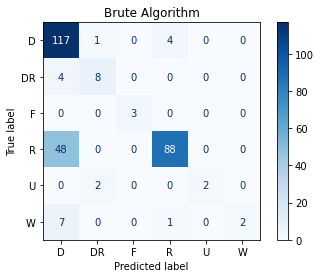

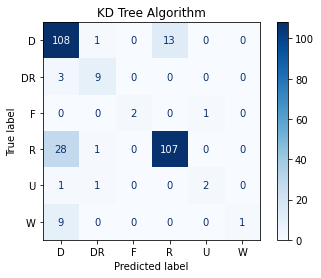

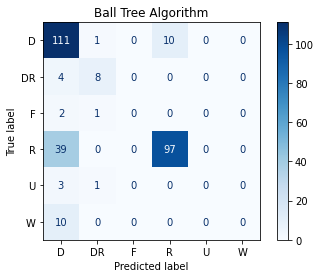

accuracy (brute): 0.7665505226480837
accuracy (kd-tree): 0.7979094076655052
accuracy (ball): 0.7526132404181185


In [13]:
kneighbortest2('partychar')